# ***Modeling, Evaluation, Pipelines***

# ***1. Importing libraries and data***

In [189]:
#Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load data generated from the data_preparation.py
datanum = pd.read_csv("../Data/numeric_data.csv")

In [191]:
# Display information about the normalized data
print("Datos numéricos:")
datanum.info()
datanum.sample(3)

Datos numéricos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age                                                   2556 non-null   float64
 1   Work/Study Hours                                      2556 non-null   float64
 2   Depression                                            2556 non-null   int64  
 3   Working Professional or Student_Working Professional  2556 non-null   int64  
 4   Have you ever had suicidal thoughts ?_Yes             2556 non-null   int64  
 5   Dietary Habits_Healthy                                2556 non-null   int64  
 6   Dietary Habits_Moderate                               2556 non-null   int64  
 7   Dietary Habits_Unhealthy                              2556 non-null   int64  
 8   Degree_B.Arch                            

,Age,Work/Study Hours,Depression,Working Professional or Student_Working Professional,Have you ever had suicidal thoughts ?_Yes,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_B.Arch,Degree_B.Com,...,Job/Study Satisfaction_1.0,Job/Study Satisfaction_2.0,Job/Study Satisfaction_3.0,Job/Study Satisfaction_4.0,Job/Study Satisfaction_5.0,Work/Academic Pressure_1.0,Work/Academic Pressure_2.0,Work/Academic Pressure_3.0,Work/Academic Pressure_4.0,Work/Academic Pressure_5.0
1769,0.023810,0.416667,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1284,0.761905,0.083333,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2200,0.452381,0.000000,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# ***2. Data Split 70-30 and Balancing (SMOTE)***

In [193]:
# # Function for data splitting
from sklearn.model_selection import train_test_split

def dividir_datos(dataset, target_column):
     # Split the data into training and testing sets
    X = dataset.drop(target_column, axis=1)
    Y = dataset[target_column]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

In [194]:
# Function to balance numerical data with SMOTE
from imblearn.over_sampling import SMOTE

def balanceo(X_train, Y_train):
    # Apply SMOTE to the training set (70% of the data)
    smote = SMOTE(random_state=42)
    X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)

    Y_train_bal.value_counts().plot(kind='barh')
    
    return X_train_bal, Y_train_bal

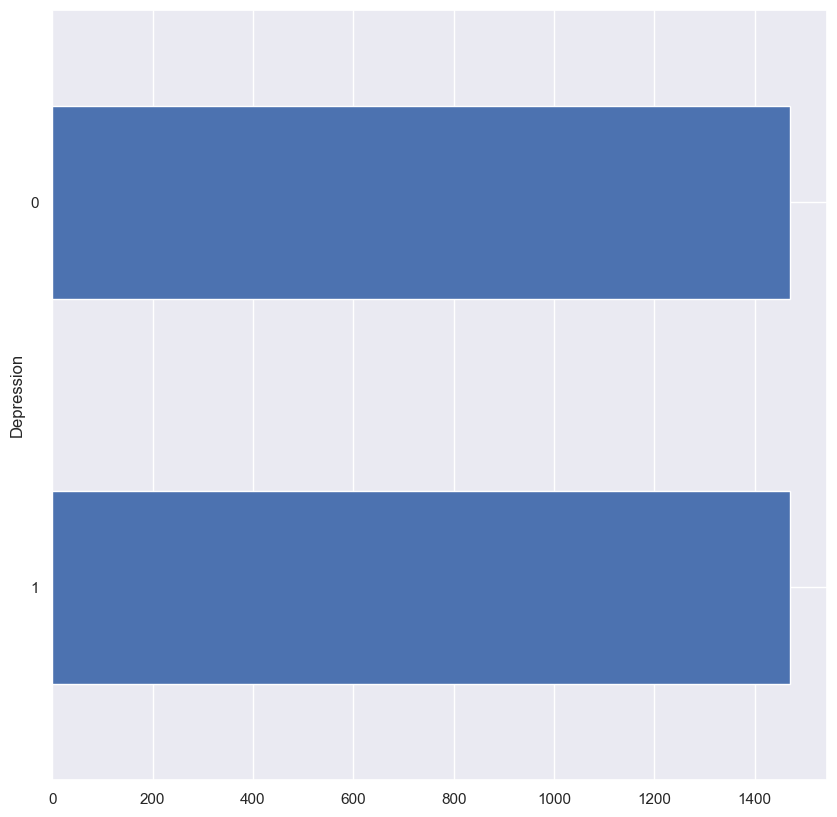

In [195]:
# Split and balance the numerical datasets
X_num_train, X_num_test, Y_num_train, Y_num_test = dividir_datos(datanum, 'Depression')
X_num_train_bal, Y_num_train_bal = balanceo(X_num_train, Y_num_train)

# ***3. Machine Learning Base Methods***

In [197]:
#Libraries for classification
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Graphics
import seaborn as sns

In [198]:
#List of base models
models = {
    "Support Vector Classifier": SVC(kernel='linear', probability=True, random_state=42),
    "Artificial Neural Network": MLPClassifier(activation="relu", hidden_layer_sizes=(26), learning_rate='constant', learning_rate_init=0.02, momentum= 0.3, max_iter=500, verbose=False, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=4, metric='euclidean'),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=2, random_state=42)
}

In [199]:
# Cross-validation configuration
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Function to perform cross-validation with cross_validate and multiple metrics
def crossValidateModels(models, X, y, cv):
    results = {}
    for model_name, model in models.items():
        # Evaluate the model with cross_validate using different metrics
        scores = cross_validate(
            model, X, y, cv=cv, 
            scoring={'accuracy': 'accuracy', 
                     'precision': 'precision_weighted', 
                     'recall': 'recall_weighted', 
                     'f1': 'f1_weighted'}, 
            return_train_score=True
        )
        
        # Store the metrics in the results dictionary
        results[model_name] = {
            "Train Accuracy Mean": scores['train_accuracy'].mean(),
            "Test Accuracy Mean": scores['test_accuracy'].mean(),
            "Train Precision Mean": scores['train_precision'].mean(),
            "Test Precision Mean": scores['test_precision'].mean(),
            "Train Recall Mean": scores['train_recall'].mean(),
            "Test Recall Mean": scores['test_recall'].mean(),
            "Train F1 Mean": scores['train_f1'].mean(),
            "Test F1 Mean": scores['test_f1'].mean(),
            "Fit Time Mean": scores['fit_time'].mean(),
            "Score Time Mean": scores['score_time'].mean()
        }

        # Print the time metrics
        print(f"Model: {model_name}")
        print(f"   - Fit Time Mean: {scores['fit_time'].mean():.4f} seconds")
        print(f"   - Score Time Mean: {scores['score_time'].mean():.4f} seconds\n")
    
    return results


In [200]:
#Crossvalidation for all models
metrics = crossValidateModels(models, X_num_train_bal, Y_num_train_bal, cv)

Model: Support Vector Classifier
   - Fit Time Mean: 0.1746 seconds
   - Score Time Mean: 0.0055 seconds

Model: Artificial Neural Network
   - Fit Time Mean: 0.2622 seconds
   - Score Time Mean: 0.0095 seconds

Model: K-Nearest Neighbors
   - Fit Time Mean: 0.0055 seconds
   - Score Time Mean: 0.0223 seconds

Model: Logistic Regression
   - Fit Time Mean: 0.0436 seconds
   - Score Time Mean: 0.0073 seconds

Model: Decision Tree
   - Fit Time Mean: 0.0066 seconds
   - Score Time Mean: 0.0055 seconds



In [201]:
# Cross-validation metrics
pd.DataFrame(metrics)

,Support Vector Classifier,Artificial Neural Network,K-Nearest Neighbors,Logistic Regression,Decision Tree
Train Accuracy Mean,0.981003,0.999887,0.943651,0.981116,0.833938
Test Accuracy Mean,0.974506,0.969410,0.887150,0.975191,0.828010
Train Precision Mean,0.981040,0.999887,0.948559,0.981128,0.834647
Test Precision Mean,0.974901,0.969981,0.906181,0.975587,0.830570
Train Recall Mean,0.981003,0.999887,0.943651,0.981116,0.833938
Test Recall Mean,0.974506,0.969410,0.887150,0.975191,0.828010
Train F1 Mean,0.981003,0.999887,0.943496,0.981116,0.833837
Test F1 Mean,0.974500,0.969399,0.885750,0.975185,0.827628
Fit Time Mean,0.174600,0.262223,0.005466,0.043607,0.006557
Score Time Mean,0.005492,0.009462,0.022312,0.007303,0.005548


In [202]:
# Function to train all models in the dictionary
def train_models(models, X_train, y_train):
    # Dictionary to store the trained models
    trained_models = {}
    
    # Train each model in the dictionary
    for model_name, model in models.items():
        print(f"Training model: {model_name}")
        model.fit(X_train, y_train)
        trained_models[model_name] = model  # Save the trained model
    
    return trained_models


In [203]:
# Function to evaluate the trained models
def evaluate_model(model, X_test, y_test, model_name):
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Create a figure with subplots for confusion matrix and ROC curve (if applicable)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Model: {model_name}', fontsize=16)

    # Plot confusion matrix in the left subplot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot ROC curve
    if hasattr(model, "predict_proba"):  # Check if the model supports predict_proba
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1].set_title('ROC Curve')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc="lower right")
        
    else:
        # roc_auc = None
        axes[1].axis('off')
    
    # Display the organized figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Return metrics in a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc if 'roc_auc' in locals() else None
    }


In [204]:
# Train all models with the balanced training data and evaluate them
def metrics(models, X_test, y_test):
    # Create an empty DataFrame with metrics as the index
    metrics_df = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
    
    for model_name, model in models.items():
        # Evaluate the model and get metrics
        metrics = evaluate_model(model, X_test, y_test, model_name)
        
        # Add the results to the DataFrame
        metrics_df[model_name] = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1'], metrics['auc']]
    
    return metrics_df


Training model: Support Vector Classifier
Training model: Artificial Neural Network
Training model: K-Nearest Neighbors
Training model: Logistic Regression
Training model: Decision Tree


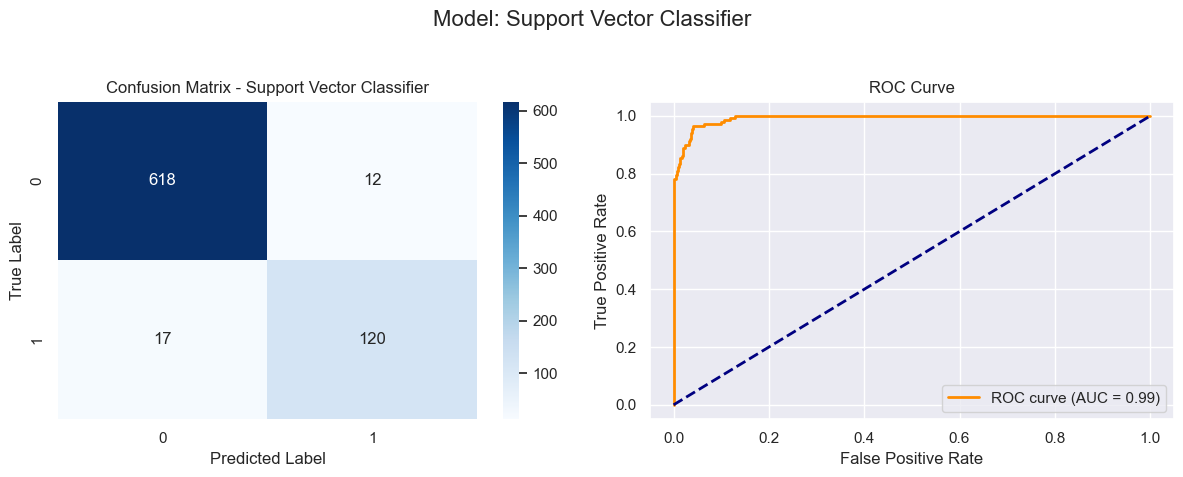

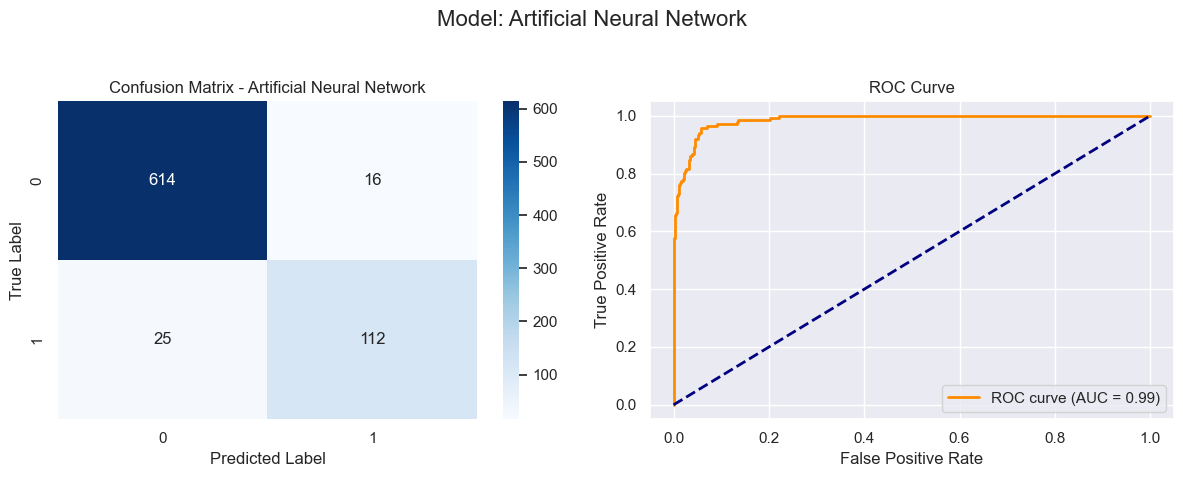

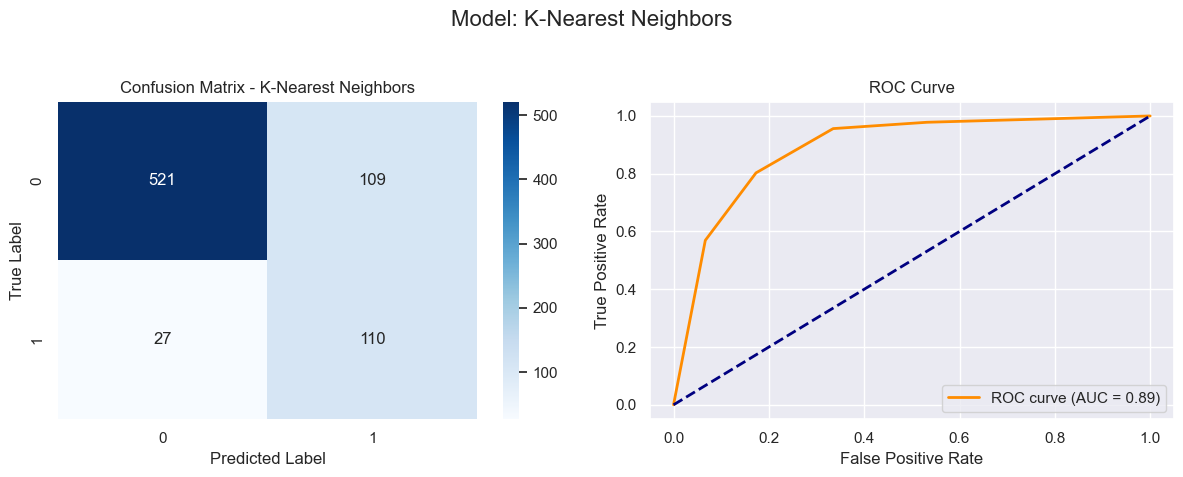

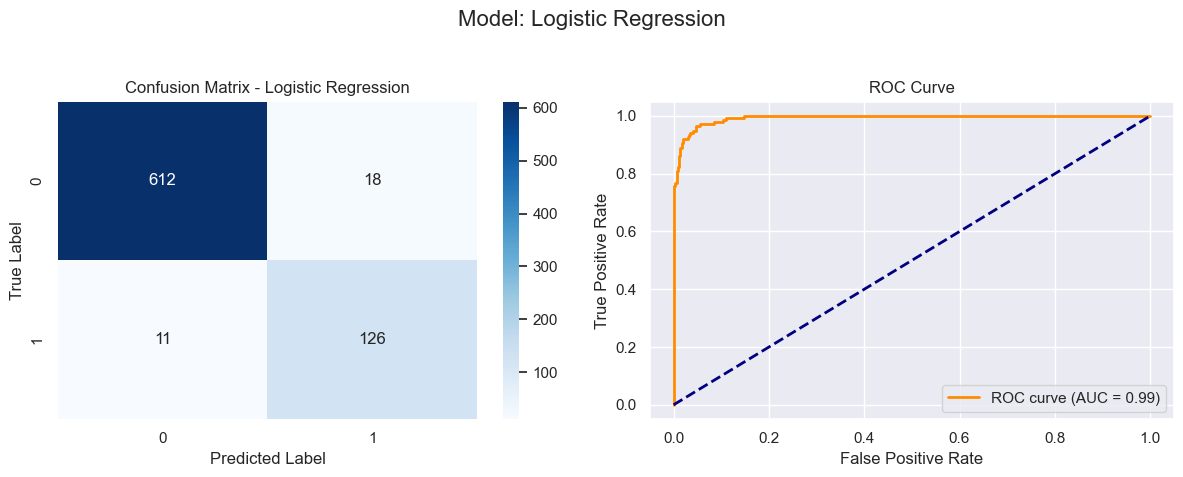

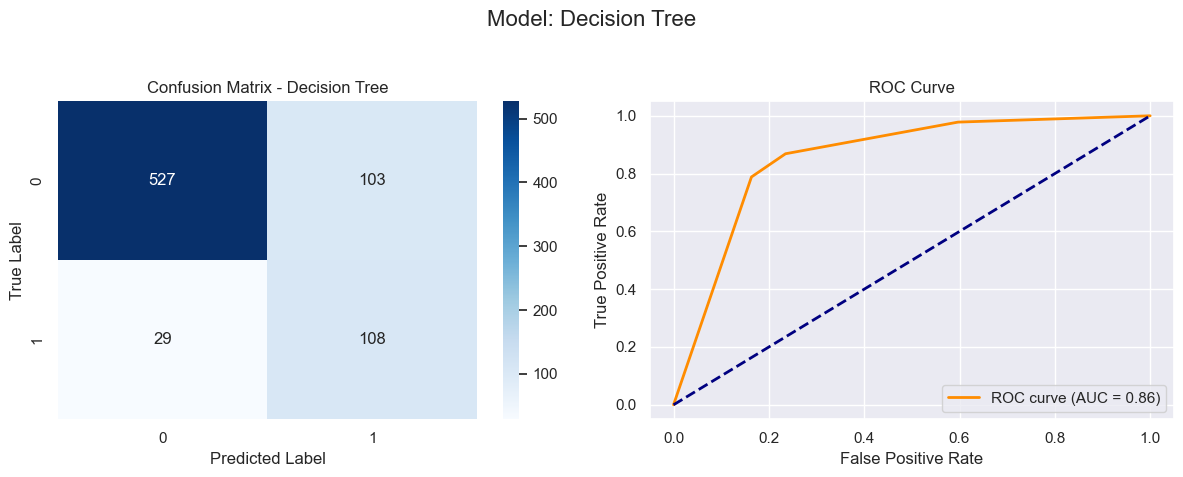

In [205]:
# Train the models and calculate their metrics and evaluation plots
trained_models = train_models(models, X_num_train_bal, Y_num_train_bal)
metrics_df = metrics(trained_models, X_num_test, Y_num_test)

In [206]:
# View the metrics of the base models
metrics_df

,Support Vector Classifier,Artificial Neural Network,K-Nearest Neighbors,Logistic Regression,Decision Tree
accuracy,0.962190,0.946545,0.822686,0.962190,0.827901
precision,0.961772,0.945537,0.870629,0.963170,0.869965
recall,0.962190,0.946545,0.822686,0.962190,0.827901
f1,0.961914,0.945827,0.836935,0.962556,0.840830
auc,0.992191,0.985401,0.887840,0.992851,0.856546


# ***4. Ensemble Methods***

In [207]:
#Libraries for ensemble models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [208]:
# Definition of ensemble models
ensemble_models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_samples=0.7, criterion='gini', max_depth=None, min_samples_leaf=2, random_state=42),
    "XGBoost": XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=100, subsample=0.8),
    "CatBoost": CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, verbose=False, random_state=42),
}

# Adding a Voting Hard model by combining some of the previous classifiers
clasif = [
    ('rf', ensemble_models["Random Forest"]),
    ('xgb', ensemble_models["XGBoost"]),
    ('cat', ensemble_models["CatBoost"])
]

voting_clf = VotingClassifier(estimators=clasif, voting='hard')

ensemble_models["Voting Hard"] = voting_clf

In [209]:
# Cross-validation for ensemble models
ensemble_metrics = crossValidateModels(ensemble_models, X_num_train_bal, Y_num_train_bal, cv)

Model: Random Forest
   - Fit Time Mean: 0.4057 seconds
   - Score Time Mean: 0.0157 seconds

Model: XGBoost
   - Fit Time Mean: 0.1609 seconds
   - Score Time Mean: 0.0202 seconds

Model: CatBoost
   - Fit Time Mean: 0.7081 seconds
   - Score Time Mean: 0.0180 seconds

Model: Voting Hard
   - Fit Time Mean: 1.1450 seconds
   - Score Time Mean: 0.0311 seconds



In [210]:
# Display the metrics of the ensemble models by cross-validation
pd.DataFrame(ensemble_metrics)

,Random Forest,XGBoost,CatBoost,Voting Hard
Train Accuracy Mean,0.992900,0.999660,1.000000,0.999736
Test Accuracy Mean,0.960234,0.969072,0.969752,0.968733
Train Precision Mean,0.992931,0.999660,1.000000,0.999736
Test Precision Mean,0.960924,0.969439,0.970378,0.969244
Train Recall Mean,0.992900,0.999660,1.000000,0.999736
Test Recall Mean,0.960234,0.969072,0.969752,0.968733
Train F1 Mean,0.992900,0.999660,1.000000,0.999736
Test F1 Mean,0.960219,0.969065,0.969742,0.968723
Fit Time Mean,0.405722,0.160857,0.708148,1.145017
Score Time Mean,0.015660,0.020192,0.017964,0.031148


Training model: Random Forest
Training model: XGBoost
Training model: CatBoost
Training model: Voting Hard


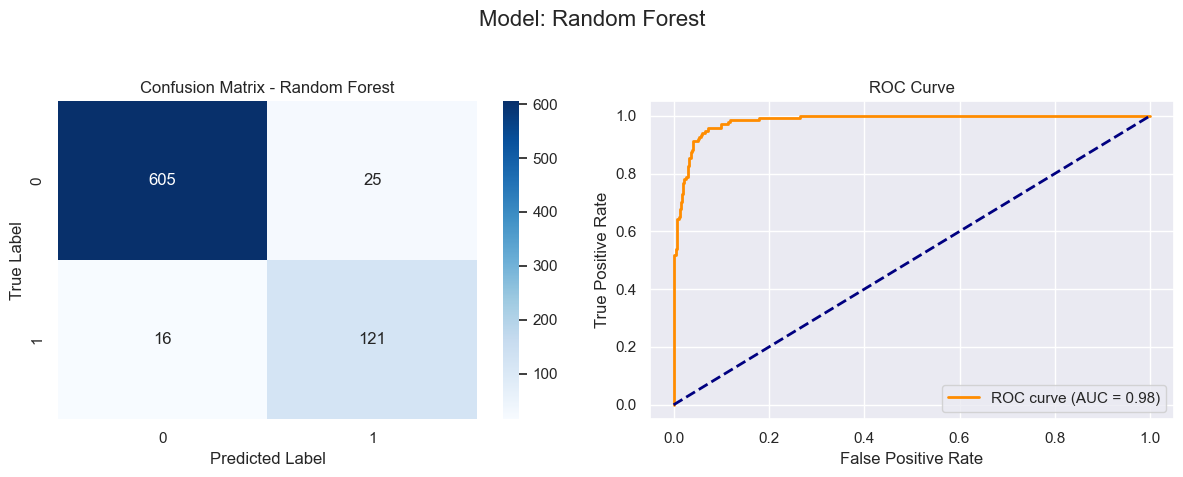

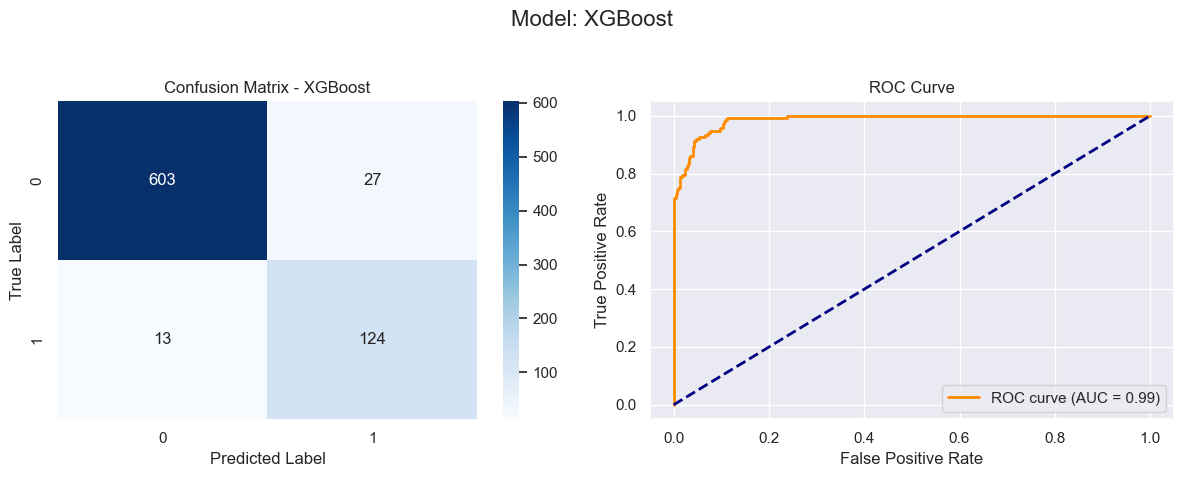

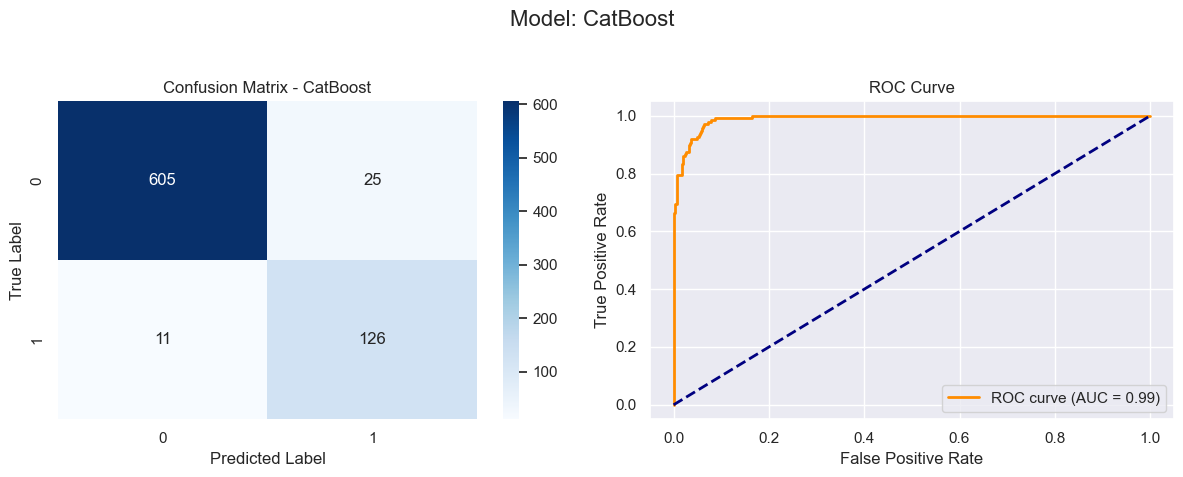

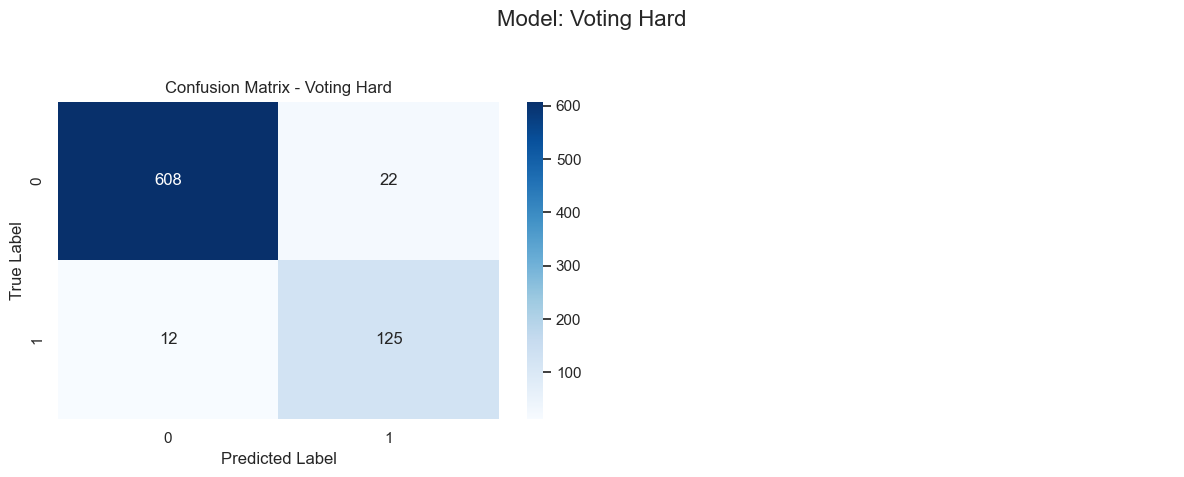

In [211]:
# Train the ensemble models and calculate their metrics and evaluation plots
ensemble_trained = train_models(ensemble_models, X_num_train_bal, Y_num_train_bal)

# View the metrics of the ensemble models
ensemble_metrics_df = metrics(ensemble_trained, X_num_test, Y_num_test)

In [212]:
# View the metrics of the ensemble models
ensemble_metrics_df

,Random Forest,XGBoost,CatBoost,Voting Hard
accuracy,0.946545,0.947849,0.953064,0.955671
precision,0.948252,0.950727,0.955760,0.957370
recall,0.946545,0.947849,0.953064,0.955671
f1,0.947203,0.948823,0.953941,0.956275
auc,0.983189,0.986479,0.990314,NaN


# ***5. ANOVA and Tukey (Analysis of statistically significant difference)***

In [213]:
# Concatenate the two DataFrames by columns
eval_metrics = pd.concat([metrics_df, ensemble_metrics_df], axis=1)

# Display the combined DataFrame
eval_metrics

,Support Vector Classifier,Artificial Neural Network,K-Nearest Neighbors,Logistic Regression,Decision Tree,Random Forest,XGBoost,CatBoost,Voting Hard
accuracy,0.962190,0.946545,0.822686,0.962190,0.827901,0.946545,0.947849,0.953064,0.955671
precision,0.961772,0.945537,0.870629,0.963170,0.869965,0.948252,0.950727,0.955760,0.957370
recall,0.962190,0.946545,0.822686,0.962190,0.827901,0.946545,0.947849,0.953064,0.955671
f1,0.961914,0.945827,0.836935,0.962556,0.840830,0.947203,0.948823,0.953941,0.956275
auc,0.992191,0.985401,0.887840,0.992851,0.856546,0.983189,0.986479,0.990314,NaN


In [214]:
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Obtain multiple F1-scores for each model through cross-validation
f1_scores_cv = {
    model_name: cross_val_score(model, X_num_train_bal, Y_num_train_bal, cv=10, scoring='f1_weighted')
    for model_name, model in trained_models.items()
}

# Convert the F1-scores into a DataFrame for ANOVA
f1_data = pd.DataFrame(f1_scores_cv)

# ANOVA analysis
anova_result = f_oneway(*[f1_data[model_name] for model_name in f1_data.columns])
print("ANOVA Result:", anova_result)

# Tukey's test
f1_data_melted = f1_data.melt(var_name='Model', value_name='F1 Score')
tukey_result = pairwise_tukeyhsd(endog=f1_data_melted['F1 Score'], groups=f1_data_melted['Model'], alpha=0.05)
print(tukey_result)

ANOVA Result: F_onewayResult(statistic=68.08448532850731, pvalue=1.6623924127562773e-18)
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
Artificial Neural Network             Decision Tree  -0.1399    0.0 -0.1717 -0.1082   True
Artificial Neural Network       K-Nearest Neighbors  -0.0875    0.0 -0.1192 -0.0558   True
Artificial Neural Network       Logistic Regression   0.0017 0.9999   -0.03  0.0334  False
Artificial Neural Network Support Vector Classifier  -0.0007    1.0 -0.0325   0.031  False
            Decision Tree       K-Nearest Neighbors   0.0524 0.0002  0.0207  0.0842   True
            Decision Tree       Logistic Regression   0.1416    0.0  0.1099  0.1734   True
            Decision Tree Support Vector Classifier   0.1392    0.0  0.1075   0.171   True
 

In [215]:
# Get multiple F1-scores for each individual model through cross-validation
f1_scores_cv_individual = {
    model_name: cross_val_score(model, X_num_train_bal, Y_num_train_bal, cv=10, scoring='f1_weighted')
    for model_name, model in trained_models.items()
}

# Get multiple F1-scores for each ensemble model through cross-validation
f1_scores_cv_ensemble = {
    model_name: cross_val_score(model, X_num_train_bal, Y_num_train_bal, cv=10, scoring='f1_weighted')
    for model_name, model in ensemble_trained.items()
}

# Combine the results into a single dictionary
f1_scores_cv_all = {**f1_scores_cv_individual, **f1_scores_cv_ensemble}

# Convert the F1-scores into a DataFrame for ANOVA
f1_data = pd.DataFrame(f1_scores_cv_all)

# ANOVA analysis for all models
anova_result = f_oneway(*[f1_data[model_name] for model_name in f1_data.columns])
print("ANOVA Result:", anova_result)

# Tukey's test to compare all models
# Restructure the DataFrame to work with Tukey's test
f1_data_melted = f1_data.melt(var_name='Model', value_name='F1 Score')
tukey_result = pairwise_tukeyhsd(endog=f1_data_melted['F1 Score'], groups=f1_data_melted['Model'], alpha=0.05)
pd.set_option('display.max_rows', None)
print(tukey_result)

ANOVA Result: F_onewayResult(statistic=58.16130294309373, pvalue=2.1435826393907352e-30)
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
Artificial Neural Network                  CatBoost  -0.0003    1.0 -0.0304  0.0298  False
Artificial Neural Network             Decision Tree  -0.1399    0.0   -0.17 -0.1098   True
Artificial Neural Network       K-Nearest Neighbors  -0.0875    0.0 -0.1176 -0.0574   True
Artificial Neural Network       Logistic Regression   0.0017    1.0 -0.0284  0.0318  False
Artificial Neural Network             Random Forest  -0.0099 0.9803   -0.04  0.0203  False
Artificial Neural Network Support Vector Classifier  -0.0007    1.0 -0.0308  0.0294  False
Artificial Neural Network               Voting Hard   -0.003    1.0 -0.0331  0.0271  False
A

In [216]:
# Filter the pairs where there is no significant difference (reject = False)
tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
similar_models = tukey_df[tukey_df['reject'] == False]

# List the similar models in a set
model_groups = set(similar_models['group1']).union(set(similar_models['group2']))

# Display the models selected with no significant differences
print("Models with no significant differences (reject=False):")
print(model_groups)

# Evaluate the selected models based on average F1-score and other metrics
selected_models = {model_name: f1_scores_cv_all[model_name].mean() for model_name in model_groups}

# Sort models by average F1-score in descending order
sorted_models = sorted(selected_models.items(), key=lambda x: x[1], reverse=True)

print("\nSelected models sorted by average F1-score:")
for model, f1 in sorted_models:
    print(f"{model}: Average F1-score = {f1:.4f}")


Models with no significant differences (reject=False):
{'Support Vector Classifier', 'CatBoost', 'Random Forest', 'Voting Hard', 'Artificial Neural Network', 'XGBoost', 'Logistic Regression'}

Selected models sorted by average F1-score:
Logistic Regression: Average F1-score = 0.9725
Artificial Neural Network: Average F1-score = 0.9708
CatBoost: Average F1-score = 0.9704
Support Vector Classifier: Average F1-score = 0.9700
Voting Hard: Average F1-score = 0.9677
XGBoost: Average F1-score = 0.9664
Random Forest: Average F1-score = 0.9609


In [217]:
from sklearn.model_selection import cross_validate
import pandas as pd

# List of selected models to measure execution time
selected_models = {
    "Logistic Regression": trained_models["Logistic Regression"],
    "CatBoost": ensemble_trained["CatBoost"],
    "Support Vector Classifier": trained_models["Support Vector Classifier"],
    "Voting Hard": ensemble_trained["Voting Hard"],
    "XGBoost": ensemble_trained["XGBoost"],
    "Artificial Neural Network": trained_models["Artificial Neural Network"],
    "Random Forest": ensemble_trained["Random Forest"]
}

# Function to measure the training and testing times of the selected models using cross_validate
def measure_execution_times_with_cross_validate(models, X, y, cv=10):
    execution_times = []

    for model_name, model in models.items():
        # Use cross_validate to get fit and score times
        scores = cross_validate(model, X, y, cv=cv, scoring='f1_weighted', return_train_score=False)

        # Calculate the average training and testing times
        avg_train_time = scores['fit_time'].mean()
        avg_test_time = scores['score_time'].mean()
        avg_total_time = avg_train_time + avg_test_time

        # Print the time metrics
        print(f"Model: {model_name}")
        print(f"   - Fit Time Mean: {avg_train_time:.4f} seconds")
        print(f"   - Score Time Mean: {avg_test_time:.4f} seconds\n")

        # Store the results
        execution_times.append({
            "Model": model_name,
            "Avg Train Time (s)": avg_train_time,
            "Avg Test Time (s)": avg_test_time,
            "Avg Total Time (s)": avg_total_time
        })

    # Sort by average total time
    execution_times_sorted = sorted(execution_times, key=lambda x: x["Avg Total Time (s)"])

    return pd.DataFrame(execution_times_sorted)

# Run the function and display the model times
execution_times_df = measure_execution_times_with_cross_validate(selected_models, X_num_train_bal, Y_num_train_bal)
execution_times_df

Model: Logistic Regression
   - Fit Time Mean: 0.0147 seconds
   - Score Time Mean: 0.0026 seconds

Model: CatBoost
   - Fit Time Mean: 0.3387 seconds
   - Score Time Mean: 0.0025 seconds

Model: Support Vector Classifier
   - Fit Time Mean: 0.1485 seconds
   - Score Time Mean: 0.0035 seconds

Model: Voting Hard
   - Fit Time Mean: 0.8198 seconds
   - Score Time Mean: 0.0207 seconds

Model: XGBoost
   - Fit Time Mean: 0.1528 seconds
   - Score Time Mean: 0.0065 seconds

Model: Artificial Neural Network
   - Fit Time Mean: 0.2502 seconds
   - Score Time Mean: 0.0019 seconds

Model: Random Forest
   - Fit Time Mean: 0.3553 seconds
   - Score Time Mean: 0.0109 seconds



,Model,Avg Train Time (s),Avg Test Time (s),Avg Total Time (s)
0,Logistic Regression,0.014681,0.002616,0.017297
1,Support Vector Classifier,0.148497,0.003470,0.151967
2,XGBoost,0.152764,0.006519,0.159283
3,Artificial Neural Network,0.250233,0.001918,0.252152
4,CatBoost,0.338749,0.002469,0.341218
5,Random Forest,0.355333,0.010921,0.366254
6,Voting Hard,0.819814,0.020741,0.840555


# ***6. Hyperparametrization***

***GridSearch and optimization (genetic algorithms/Bayesian optimization).***

### Gridsearch

In [218]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for each model
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

param_grid_xgb = {
    'max_depth': np.arange(3, 8, 1),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'n_estimators': [100, 200, 300, 500]
}


# Grid Search function
def grid_search_optimization(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Run GridSearchCV for each model
svc_best, svc_params = grid_search_optimization(SVC(random_state=42), param_grid_svc, X_num_train_bal, Y_num_train_bal)
logistic_best, logistic_params = grid_search_optimization(LogisticRegression(random_state=42), param_grid_logistic, X_num_train_bal, Y_num_train_bal)
xgb_best, xgb_params = grid_search_optimization(XGBClassifier(eval_metric='logloss', random_state=42), param_grid_xgb, X_num_train_bal, Y_num_train_bal)

print("Best SVC parameters (GridSearch):", svc_params)
print("Best Logistic Regression parameters (GridSearch):", logistic_params)
print("Best XGBoost parameters (GridSearch):", xgb_params)


/Users/simon/Documents/Depression Simon/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best SVC parameters (GridSearch): {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Logistic Regression parameters (GridSearch): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best XGBoost parameters (GridSearch): {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 500}


### BayesSearch

In [219]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define search space for each model
param_bayes_svc = {
    'C': Real(0.1, 10),
    'gamma': Real(0.001, 1),
    'kernel': ['linear', 'rbf']
}

param_bayes_logistic = {
    'C': Real(0.01, 10),
    'solver': ['lbfgs', 'liblinear']
}

param_bayes_xgb = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 500)
}

# Bayes Search function
def bayes_search_optimization(model, param_grid, X_train, y_train):
    bayes_search = BayesSearchCV(model, param_grid, n_iter=50, cv=10, scoring='f1_weighted', n_jobs=-1, refit=True)
    bayes_search.fit(X_train, y_train)
    return bayes_search.best_estimator_, bayes_search.best_params_

# Run BayesSearchCV for each model
svc_bayes_best, svc_bayes_params = bayes_search_optimization(SVC(random_state=42), param_bayes_svc, X_num_train_bal, Y_num_train_bal)
logistic_bayes_best, logistic_bayes_params = bayes_search_optimization(LogisticRegression(random_state=42), param_bayes_logistic, X_num_train_bal, Y_num_train_bal)
xgb_bayes_best, xgb_bayes_params = bayes_search_optimization(XGBClassifier(eval_metric='logloss', random_state=42), param_bayes_xgb, X_num_train_bal, Y_num_train_bal)

print("Best SVC parameters (BayesSearch):", svc_bayes_params)
print("Best Logistic Regression parameters (BayesSearch):", logistic_bayes_params)
print("Best XGBoost parameters (BayesSearch):", xgb_bayes_params)

Best SVC parameters (BayesSearch): OrderedDict({'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'})
Best Logistic Regression parameters (BayesSearch): OrderedDict({'C': 6.248965950939057, 'solver': 'liblinear'})
Best XGBoost parameters (BayesSearch): OrderedDict({'learning_rate': 0.13233505338503568, 'max_depth': 3, 'n_estimators': 432})


### GASearchCV

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.964785	0.00921795 	0.973122   	0.937384   
1  	40    	0.971102	0.0017828  	0.973122   	0.965178   
2  	40    	0.972575	0.000721516	0.973122   	0.97072    
3  	40    	0.973019	0.000268082	0.973123   	0.972098   
4  	40    	0.973105	7.41404e-05	0.973123   	0.972782   
5  	40    	0.973122	4.42875e-07	0.973123   	0.973122   
6  	40    	0.973139	7.48059e-05	0.973465   	0.973122   
7  	40    	0.973191	0.000137186	0.973465   	0.973122   
8  	40    	0.973243	0.000163513	0.973465   	0.973122   
9  	40    	0.973191	0.000514356	0.973465   	0.971071   
10 	40    	0.97338 	0.000148341	0.973465   	0.973123   
11 	40    	0.973448	7.46636e-05	0.973465   	0.973123   
12 	40    	0.973465	5.55112e-16	0.973465   	0.973465   
13 	40    	0.973379	0.00037491 	0.973465   	0.971745   
14 	40    	0.973465	5.55112e-16	0.973465   	0.973465   
15 	40    	0.973465	5.55112e-16	0.973465   	0.973465   
16 	40    	0.973465	5.55112e-16	0.973465   	0.97

/Users/simon/Documents/Depression Simon/venv/lib/python3.12/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


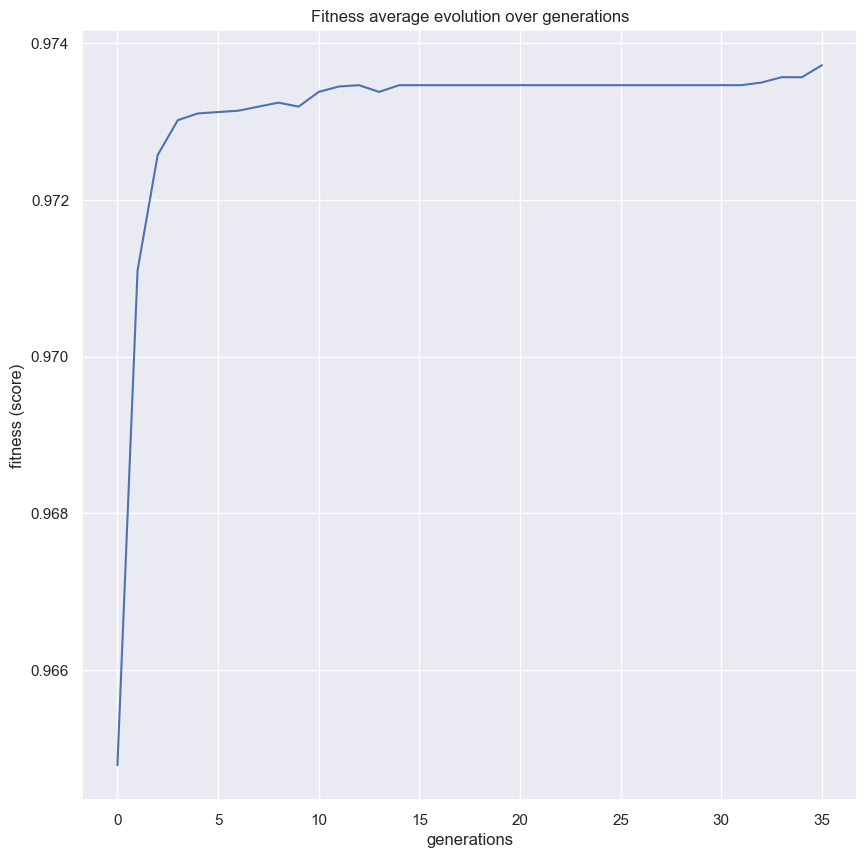

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.972748	0.00369238 	0.974498   	0.956833   
1  	40    	0.973853	0.000414389	0.974498   	0.973475   
2  	40    	0.974057	0.000430022	0.974498   	0.973474   
3  	40    	0.974362	0.00032941 	0.974498   	0.973474   
4  	40    	0.974498	5.55112e-16	0.974498   	0.974498   
5  	40    	0.974498	5.55112e-16	0.974498   	0.974498   
6  	40    	0.974498	5.55112e-16	0.974498   	0.974498   
7  	40    	0.974498	5.55112e-16	0.974498   	0.974498   
8  	40    	0.974464	0.000148322	0.974498   	0.973818   
9  	40    	0.974498	5.55112e-16	0.974498   	0.974498   
10 	40    	0.974464	0.000148702	0.974498   	0.973816   
11 	40    	0.974498	5.55112e-16	0.974498   	0.974498   
12 	40    	0.974498	5.55112e-16	0.974498   	0.974498   
13 	40    	0.974498	5.55112e-16	0.974498   	0.974498   
14 	40    	0.974498	5.55112e-16	0.974498   	0.974498   
15 	40    	0.974498	5.55112e-16	0.974498   	0.974498   
16 	40    	0.974498	5.55112e-16	0.974498   	0.97

/Users/simon/Documents/Depression Simon/venv/lib/python3.12/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


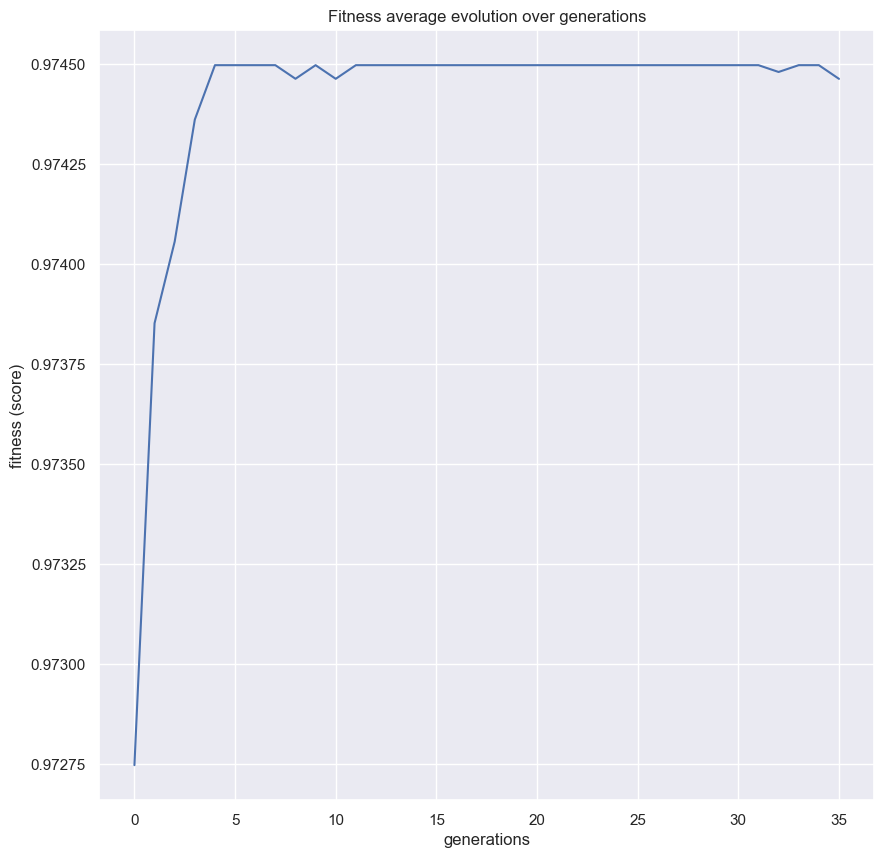

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.969189	0.00206422 	0.973152   	0.964308   
1  	40    	0.970736	0.00178981 	0.973491   	0.966353   
2  	40    	0.972285	0.00117606 	0.974173   	0.969753   
3  	40    	0.972081	0.00095748 	0.973154   	0.969753   
4  	40    	0.972795	0.00097664 	0.974173   	0.970088   
5  	40    	0.973408	0.000774319	0.974173   	0.971791   
6  	40    	0.973646	0.000717419	0.974173   	0.971449   
7  	40    	0.973731	0.000559349	0.974173   	0.972475   
8  	40    	0.973543	0.00100438 	0.974173   	0.970433   
9  	40    	0.97402 	0.00040948 	0.974174   	0.972475   
10 	40    	0.974241	0.000231952	0.974514   	0.973487   
11 	40    	0.974054	0.000778288	0.974514   	0.971451   
12 	40    	0.973663	0.00152812 	0.974514   	0.969741   
13 	40    	0.974123	0.00139966 	0.974514   	0.968051   
14 	40    	0.974429	0.000302414	0.974514   	0.973151   
15 	40    	0.97448 	0.000102335	0.974514   	0.974173   
16 	40    	0.974106	0.00122532 	0.974514   	0.96

/Users/simon/Documents/Depression Simon/venv/lib/python3.12/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


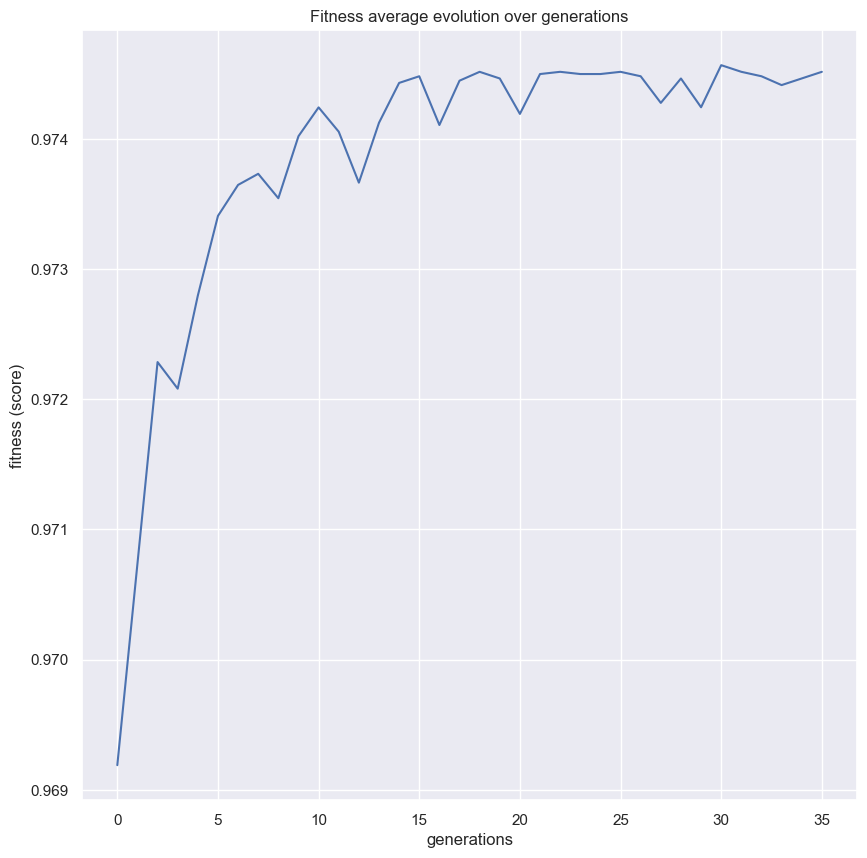

Best SVC parameters (GASearch): {'C': 9.970582795643567, 'gamma': 0.8906785125606723, 'kernel': 'linear'}
Best Logistic Regression parameters (GASearch): {'C': 7.768765567128024, 'solver': 'liblinear'}
Best XGBoost parameters (GASearch): {'max_depth': 3, 'learning_rate': 0.07895655416904496, 'n_estimators': 489}


In [220]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder*")

# Define search space for each model
param_ga_svc = {
    'C': Continuous(0.1, 10),
    'gamma': Continuous(0.001, 1),
    'kernel': Categorical(['linear', 'rbf'])
}

param_ga_logistic = {
    'C': Continuous(0.01, 10),
    'solver': Categorical(['lbfgs', 'liblinear'])
}

param_ga_xgb = {
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'n_estimators': Integer(100, 500)
}

# Define common configuration for GASearchCV
def ga_search_optimization(model, param_grid, X_train, y_train, scoring='f1_weighted'):
    ga_search = GASearchCV(
        estimator=model,
        cv=10,
        scoring=scoring,
        population_size=20,
        generations=35,
        elitism=True,
        crossover_probability=0.4,
        mutation_probability=0.6,
        param_grid=param_grid,
        criteria='max',
        verbose=True,
        n_jobs=-1
    )
    ga_search.fit(X_train, y_train)
    
    # Show fitness evolution
    plot_fitness_evolution(ga_search)
    plt.show()
    
    # Return the best estimator and its parameters
    return ga_search.best_estimator_, ga_search.best_params_

# Run GASearchCV for each model and evaluate
svc_ga_best, svc_ga_params = ga_search_optimization(SVC(random_state=42), param_ga_svc, X_num_train_bal, Y_num_train_bal)
logistic_ga_best, logistic_ga_params = ga_search_optimization(LogisticRegression(random_state=42), param_ga_logistic, X_num_train_bal, Y_num_train_bal)
xgb_ga_best, xgb_ga_params = ga_search_optimization(XGBClassifier(eval_metric='logloss', random_state=42), param_ga_xgb, X_num_train_bal, Y_num_train_bal)

print("Best SVC parameters (GASearch):", svc_ga_params)
print("Best Logistic Regression parameters (GASearch):", logistic_ga_params)
print("Best XGBoost parameters (GASearch):", xgb_ga_params)

In [221]:
# Resumen de los mejores modelos y sus parámetros
print("SVC:")
print(f"GridSearch Best Params: {svc_params}")
print(f"BayesSearch Best Params: {svc_bayes_params}")
print(f"GASearch Best Params: {svc_ga_params}\n")

print("Logistic Regression:")
print(f"GridSearch Best Params: {logistic_params}")
print(f"BayesSearch Best Params: {logistic_bayes_params}")
print(f"GASearch Best Params: {logistic_ga_params}\n")

print("XGBoost:")
print(f"GridSearch Best Params: {xgb_params}")
print(f"BayesSearch Best Params: {xgb_bayes_params}")
print(f"GASearch Best Params: {xgb_ga_params}")


SVC:
GridSearch Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
BayesSearch Best Params: OrderedDict({'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'})
GASearch Best Params: {'C': 9.970582795643567, 'gamma': 0.8906785125606723, 'kernel': 'linear'}

Logistic Regression:
GridSearch Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
BayesSearch Best Params: OrderedDict({'C': 6.248965950939057, 'solver': 'liblinear'})
GASearch Best Params: {'C': 7.768765567128024, 'solver': 'liblinear'}

XGBoost:
GridSearch Best Params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 500}
BayesSearch Best Params: OrderedDict({'learning_rate': 0.13233505338503568, 'max_depth': 3, 'n_estimators': 432})
GASearch Best Params: {'max_depth': 3, 'learning_rate': 0.07895655416904496, 'n_estimators': 489}


In [222]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# Lista de modelos optimizados
optimized_models = {
    'SVC': SVC(C=10, gamma=1.0, kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(C=8.47, solver='liblinear', random_state=42),
    'XGBoost': XGBClassifier(learning_rate=0.077, max_depth=3, n_estimators=441, random_state=42)
}

# Función para evaluar los modelos
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for model_name, model in models.items():
        # Entrenar el modelo
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()

        # Tiempo de entrenamiento
        train_time = end_train - start_train

        # Predicción
        start_pred = time.time()
        y_pred = model.predict(X_test)
        end_pred = time.time()

        # Tiempo de predicción
        pred_time = end_pred - start_pred

        # Métricas de rendimiento
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # AUC (solo si el modelo soporta predict_proba)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = None

        # Almacenar resultados
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'Train Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })

    return pd.DataFrame(results)

# Evaluación de los modelos optimizados
results_df = evaluate_models(optimized_models, X_num_train_bal, X_num_test, Y_num_train_bal, Y_num_test)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Train Time (s),Prediction Time (s)
0,SVC,0.958279,0.958279,0.958279,0.958279,NaN,0.050352,0.006387
1,Logistic Regression,0.966102,0.966565,0.966102,0.966292,0.993118,0.008645,0.001906
2,XGBoost,0.950456,0.953244,0.950456,0.951382,0.989433,0.453269,0.018091


Mejor modelo -> Regresión Logística